<a href="https://colab.research.google.com/github/Marcos-Sanson/UC3M-ML/blob/main/LAB02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib seaborn yellowbrick ucimlrepo lifelines --upgrade

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=3e075c84d17c84677c8e336856ce01bf56bab7d92c2561f42a269263f2744fe6
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


Firstly, the dataframe is being analyzed. Therefore missing values are visualized and imputed according to their feature class (categorical or numerical).

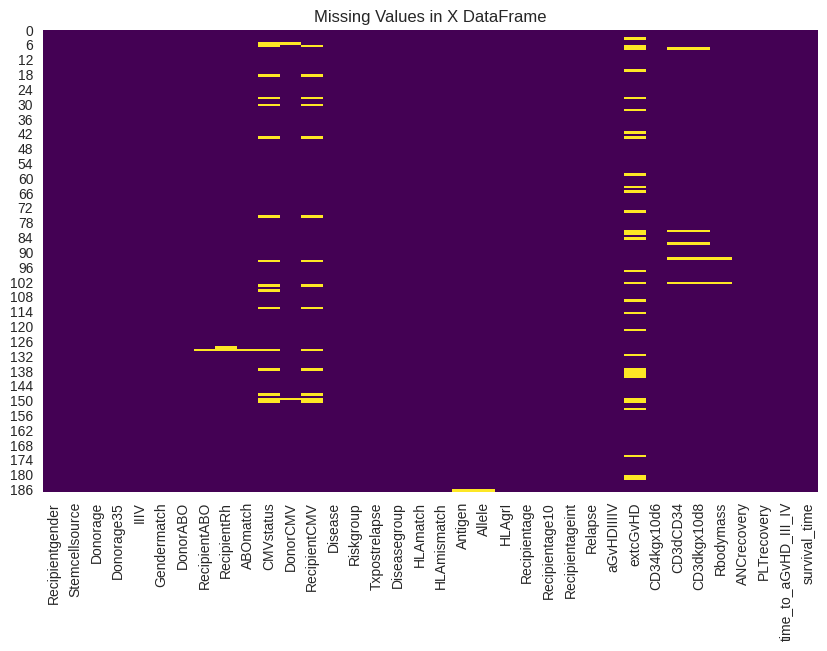

     Recipientgender  Stemcellsource   Donorage  Donorage35  IIIV  \
0                1.0             1.0  22.830137         0.0   1.0   
1                1.0             0.0  23.342466         0.0   1.0   
2                1.0             0.0  26.394521         0.0   1.0   
3                0.0             0.0  39.684932         1.0   1.0   
4                0.0             1.0  33.358904         0.0   0.0   
..               ...             ...        ...         ...   ...   
182              1.0             1.0  37.575342         1.0   1.0   
183              0.0             1.0  22.895890         0.0   0.0   
184              0.0             1.0  27.347945         0.0   1.0   
185              1.0             1.0  27.780822         0.0   1.0   
186              1.0             1.0  55.553425         1.0   1.0   

     Gendermatch  DonorABO  RecipientABO  RecipientRh  ABOmatch  ...  \
0            0.0       1.0           1.0          1.0       0.0  ...   
1            0.0      -1.0 

<ipython-input-2-022f536a4d4a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])
<ipython-input-2-022f536a4d4a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])


In [ ]:
from ucimlrepo import fetch_ucirepo
from lifelines import CoxPHFitter
import lifelines.plotting as plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# fetch dataset
bone_marrow_transplant_children = fetch_ucirepo(id=565)

# data (as pandas dataframes)
X = bone_marrow_transplant_children.data.features
y = bone_marrow_transplant_children.data.targets

# Here missing values are first visualized and then imputed according to their feature class (categorical, numerical)

# 1. Visualize Missing Values:

plt.figure(figsize=(10, 6))
sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in X DataFrame')
plt.show()

# 2. Impute Missing Values:

# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Create imputers for numerical and categorical features
numerical_imputer = SimpleImputer(strategy='mean')  # Or 'median' if appropriate
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# 3. Encode Categorical Features:

# Create a OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for DataFrame output

# Fit and transform the categorical features
encoded_data = encoder.fit_transform(X[categorical_features])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical features and concatenate encoded features
X_encoded = X.drop(columns=categorical_features).reset_index(drop=True)
X_encoded = pd.concat([X_encoded, encoded_df], axis=1)

# Now 'X_encoded' contains the imputed and encoded data
print(X_encoded)

Now the most important features are being identified using their correlation between the survival time.

In [ ]:
# Additional Variable Information

additional_variable_info = {
    "donor_age": "Age of the donor at the time of hematopoietic stem cells apheresis",
    "donor_age_below_35": "Is donor age less than 35 (yes, no)",
    "donor_ABO": "ABO blood group of the donor of hematopoietic stem cells (0, A, B, AB)",
    "donor_CMV": "Presence of cytomegalovirus infection in the donor of hematopoietic stem cells prior to transplantation (present, absent)",
    "recipient_age": "Age of the recipient of hematopoietic stem cells at the time of transplantation",
    "recipient_age_below_10": "Is recipient age below 10 (yes, no)",
    "recipient_age_int": "Age of the recipient discretized to intervals (0,5], (5, 10], (10, 20]",
    "recipient_gender": "Gender of the recipient (female, male)",
    "recipient_body_mass": "Body mass of the recipient of hematopoietic stem cells at the time of the transplantation",
    "recipient_ABO": "ABO blood group of the recipient of hematopoietic stem cells (0, A, B, AB)",
    "recipient_rh": "Presence of the Rh factor on recipient’s red blood cells (plus, minus)",
    "recipient_CMV": "Presence of cytomegalovirus infection in the donor of hematopoietic stem cells prior to transplantation (present, absent)",
    "disease": "Type of disease (ALL, AML, chronic, nonmalignant, lymphoma)",
    "disease_group": "Type of disease (malignant, nonmalignant)",
    "gender_match": "Compatibility of the donor and recipient according to their gender (female to male, other)",
    "ABO_match": "Compatibility of the donor and the recipient of hematopoietic stem cells according to ABO blood group (matched, mismatched)",
    "CMV_status": "Serological compatibility of the donor and the recipient of hematopoietic stem cells according to cytomegalovirus infection prior to transplantation (the higher the value, the lower the compatibility)",
    "HLA_match": "Compatibility of antigens of the main histocompatibility complex of the donor and the recipient of hematopoietic stem cells (10/10, 9/10, 8/10, 7/10)",
    "HLA_mismatch": "HLA matched or mismatched",
    "antigen": "In how many antigens there is a difference between the donor and the recipient (0-3)",
    "allel": "In how many allele there is a difference between the donor and the recipient (0-4)",
    "HLA_group_1": "The difference type between the donor and the recipient (HLA matched, one antigen, one allel, DRB1 cell, two allele or allel+antigen, two antigenes+allel, mismatched)",
    "risk_group": "Risk group (high, low)",
    "stem_cell_source": "Source of hematopoietic stem cells (peripheral blood, bone marrow)",
    "tx_post_relapse": "The second bone marrow transplantation after relapse (yes, no)",
    "CD34_x1e6_per_kg": "CD34kgx10d6 - CD34+ cell dose per kg of recipient body weight (10^6/kg)",
    "CD3_x1e8_per_kg": "CD3+ cell dose per kg of recipient body weight (10^8/kg)",
    "CD3_to_CD34_ratio": "CD3+ cell to CD34+ cell ratio",
    "ANC_recovery": "Neutrophils recovery defined as neutrophils count >0.5 x 10^9/L (yes, no)",
    "time_to_ANC_recovery": "Time in days to neutrophils recovery",
    "PLT_recovery": "Platelet recovery defined as platelet count >50000/mm3 (yes, no)",
    "time_to_PLT_recovery": "Time in days to platelet recovery",
    "acute_GvHD_II_III_IV": "Development of acute graft versus host disease stage II or III or IV (yes, no)",
    "acute_GvHD_III_IV": "Development of acute graft versus host disease stage III or IV (yes, no)",
    "time_to_acute_GvHD_III_IV": "Time in days to development of acute graft versus host disease stage III or IV",
    "extensive_chronic_GvHD": "Development of extensive chronic graft versus host disease (yes, no)",
    "relapse": "Relapse of the disease (yes, no)",
    "survival_time": "Time of observation (if alive) or time to event (if dead) in days",
    "survival_status": "Survival status (0 - alive, 1 - dead)"
}

# Display additional variable information with spacing
for variable, description in additional_variable_info.items():
    print(f"{variable}: {description}\n")


donor_age: Age of the donor at the time of hematopoietic stem cells apheresis

donor_age_below_35: Is donor age less than 35 (yes, no)

donor_ABO: ABO blood group of the donor of hematopoietic stem cells (0, A, B, AB)

donor_CMV: Presence of cytomegalovirus infection in the donor of hematopoietic stem cells prior to transplantation (present, absent)

recipient_age: Age of the recipient of hematopoietic stem cells at the time of transplantation

recipient_age_below_10: Is recipient age below 10 (yes, no)

recipient_age_int: Age of the recipient discretized to intervals (0,5], (5, 10], (10, 20]

recipient_gender: Gender of the recipient (female, male)

recipient_body_mass: Body mass of the recipient of hematopoietic stem cells at the time of the transplantation

recipient_ABO: ABO blood group of the recipient of hematopoietic stem cells (0, A, B, AB)

recipient_rh: Presence of the Rh factor on recipient’s red blood cells (plus, minus)

recipient_CMV: Presence of cytomegalovirus infection

In [ ]:


# Combine features and target for analysis
data = pd.concat([X_encoded, y], axis=1)
print(data.info())
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    float64
 1   Stemcellsource        187 non-null    float64
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    float64
 4   IIIV                  187 non-null    float64
 5   Gendermatch           187 non-null    float64
 6   DonorABO              187 non-null    float64
 7   RecipientABO          187 non-null    float64
 8   RecipientRh           187 non-null    float64
 9   ABOmatch              187 non-null    float64
 10  CMVstatus             187 non-null    float64
 11  DonorCMV              187 non-null    float64
 12  RecipientCMV          187 non-null    float64
 13  Riskgroup             187 non-null    float64
 14  Txpostrelapse         187 non-null    float64
 15  Diseasegroup          1

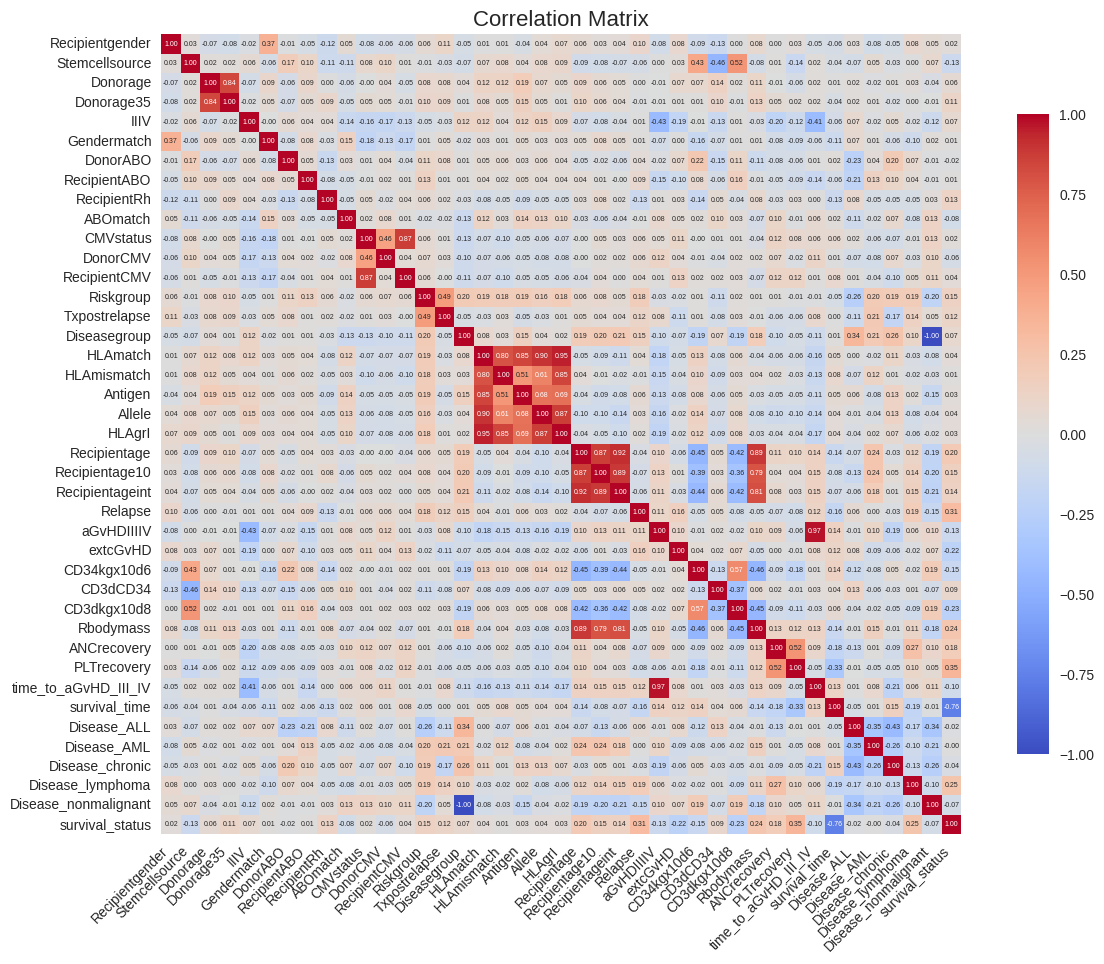

In [ ]:
# Calculate the new correlation matrix
correlation_matrix = data.corr()


# Plotting the correlation heatmap with increased spacing
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, annot_kws={"size": 5, "va": "center", "ha": "center"})

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Adjust margins
plt.show()


Features correlated with survival time:
 survival_time           1.000000
Disease_chronic         0.154440
aGvHDIIIIV              0.144717
CD34kgx10d6             0.139313
time_to_aGvHD_III_IV    0.131168
extcGvHD                0.115758
RecipientCMV            0.084111
HLAmismatch             0.078839
CMVstatus               0.064016
CD3dkgx10d8             0.059653
HLAmatch                0.054196
Antigen                 0.054054
CD3dCD34                0.043050
HLAgrI                  0.037884
Allele                  0.037598
ABOmatch                0.021973
DonorABO                0.016415
Diseasegroup            0.009649
Disease_AML             0.008434
DonorCMV                0.006917
Donorage                0.005603
Txpostrelapse           0.001266
Disease_nonmalignant   -0.009649
Stemcellsource         -0.041253
Donorage35             -0.041369
Riskgroup              -0.048790
Disease_ALL            -0.053103
Recipientgender        -0.060487
RecipientABO           -0.061942
II

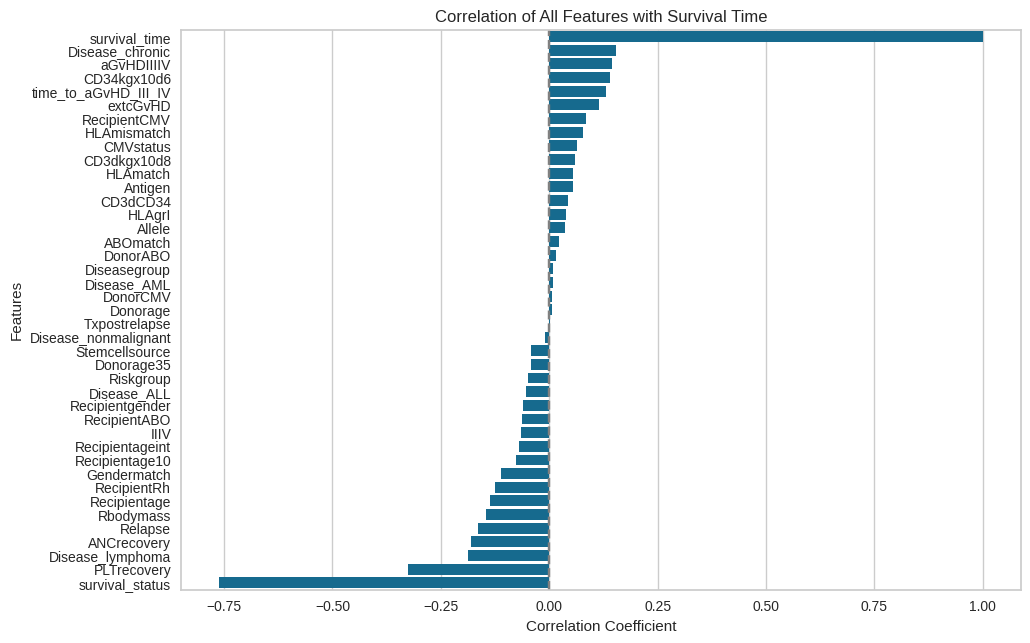

['survival_time', 'Disease_chronic', 'Relapse', 'ANCrecovery', 'Disease_lymphoma', 'PLTrecovery', 'survival_status']


In [ ]:
# Section 6: Analyze Features Correlated with Survival Time
# Check correlation with survival time for all features
survival_correlation = correlation_matrix['survival_time'].sort_values(ascending=False)
print("Features correlated with survival time:\n", survival_correlation)

# Visualize all features correlated with survival time
plt.figure(figsize=(12, 8))  # Increase figure size
sns.barplot(x=survival_correlation, y=survival_correlation.index)
plt.title('Correlation of All Features with Survival Time')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='grey', linestyle='--')  # Add a vertical line at x=0 for reference

# Increase spacing between ticks
plt.yticks(fontsize=10)  # Adjust font size of y-ticks
plt.xticks(fontsize=10)  # Adjust font size of x-ticks

# Add padding to the plot
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)  # Adjust padding

plt.show()
# Save list of most interesting features; consider features with an absolute correlation of greater than 0.15 as interesting
most_interesting_features = list(survival_correlation[abs(survival_correlation) > 0.15].index)
print(most_interesting_features)

In [ ]:
# Section 7: Identify Missing Features and Non-Correlating Features
# Check for features that do not seem to correlate with survival time (threshold can be set, e.g., < 0.1)
non_correlating_features = survival_correlation[survival_correlation.abs() < 0.1]
print("Non-correlating features with survival time:\n", non_correlating_features)

# List of missing features
missing_features = data.columns[data.isnull().any()]
print("Missing features:\n", missing_features)


Non-correlating features with survival time:
 RecipientCMV            0.084111
HLAmismatch             0.078839
CMVstatus               0.064016
CD3dkgx10d8             0.059653
HLAmatch                0.054196
Antigen                 0.054054
CD3dCD34                0.043050
HLAgrI                  0.037884
Allele                  0.037598
ABOmatch                0.021973
DonorABO                0.016415
Diseasegroup            0.009649
Disease_AML             0.008434
DonorCMV                0.006917
Donorage                0.005603
Txpostrelapse           0.001266
Disease_nonmalignant   -0.009649
Stemcellsource         -0.041253
Donorage35             -0.041369
Riskgroup              -0.048790
Disease_ALL            -0.053103
Recipientgender        -0.060487
RecipientABO           -0.061942
IIIV                   -0.064272
Recipientageint        -0.070310
Recipientage10         -0.075985
Name: survival_time, dtype: float64
Missing features:
 Index([], dtype='object')


In [ ]:
# Section 8: Jointly Correlated Features
# Analyze groups of features that are jointly correlated
jointly_correlated = correlation_matrix[abs(correlation_matrix) > 0.5].dropna(axis=1, how='all')
print("Features that are jointly correlated (|correlation| > 0.5):\n", jointly_correlated)


Features that are jointly correlated (|correlation| > 0.5):
                       Recipientgender  Stemcellsource  Donorage  Donorage35  \
Recipientgender                   1.0             NaN       NaN         NaN   
Stemcellsource                    NaN        1.000000       NaN         NaN   
Donorage                          NaN             NaN  1.000000    0.840927   
Donorage35                        NaN             NaN  0.840927    1.000000   
IIIV                              NaN             NaN       NaN         NaN   
Gendermatch                       NaN             NaN       NaN         NaN   
DonorABO                          NaN             NaN       NaN         NaN   
RecipientABO                      NaN             NaN       NaN         NaN   
RecipientRh                       NaN             NaN       NaN         NaN   
ABOmatch                          NaN             NaN       NaN         NaN   
CMVstatus                         NaN             NaN       NaN       

Here the clustering of the most important features from above is done to figure out the patient groups.

Here the elbow curve of the clustering from above is done as well as the PCA (using 2 components) for the visualization of the clustering itself.

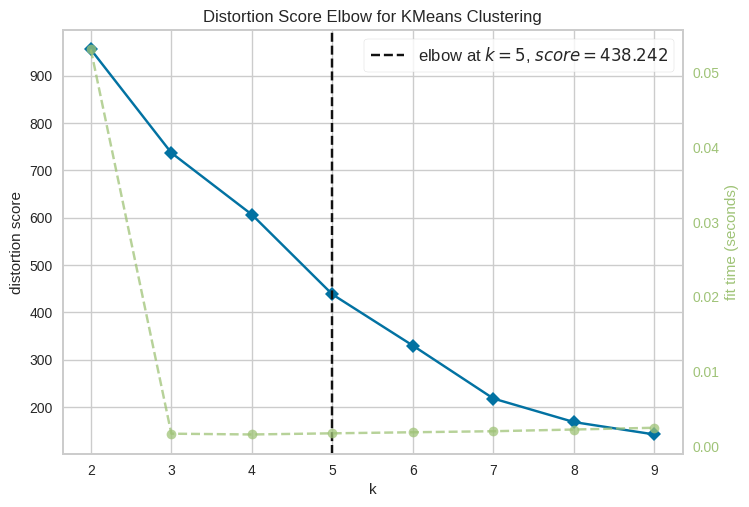

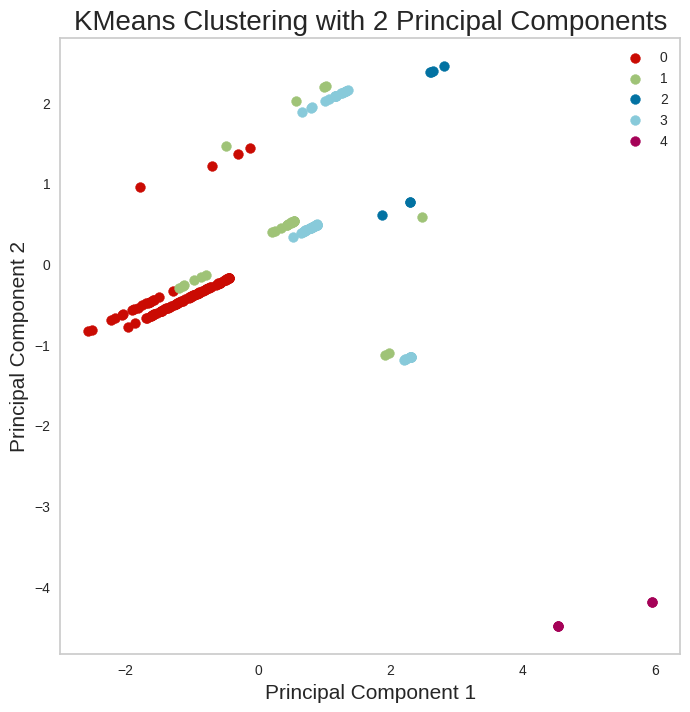

In [ ]:
# Assuming 'data_encoded' is your DataFrame with encoded features
# Extract the most interesting features for clustering
cluster_data = data[most_interesting_features]

# Impute missing values using SimpleImputer before scaling
imputer = SimpleImputer(strategy='mean')
cluster_data_imputed = imputer.fit_transform(cluster_data)

# Scale the data for better clustering performance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data_imputed)

# Elbow Method for optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10)) # Check for k values between 2 and 10

visualizer.fit(scaled_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Apply KMeans clustering with the optimal k (e.g., k=3 based on elbow method)
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)  # Use elbow_value_ for optimal k
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to your original DataFrame
data['cluster'] = clusters


# PCA for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, data[['cluster']]], axis = 1)

# Visualize the clusters using PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('KMeans Clustering with 2 Principal Components', fontsize = 20)

targets = np.unique(data['cluster']) # Get unique cluster labels
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'] # Define colors for clusters (extend if needed)

for target, color in zip(targets, colors[:len(targets)]):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

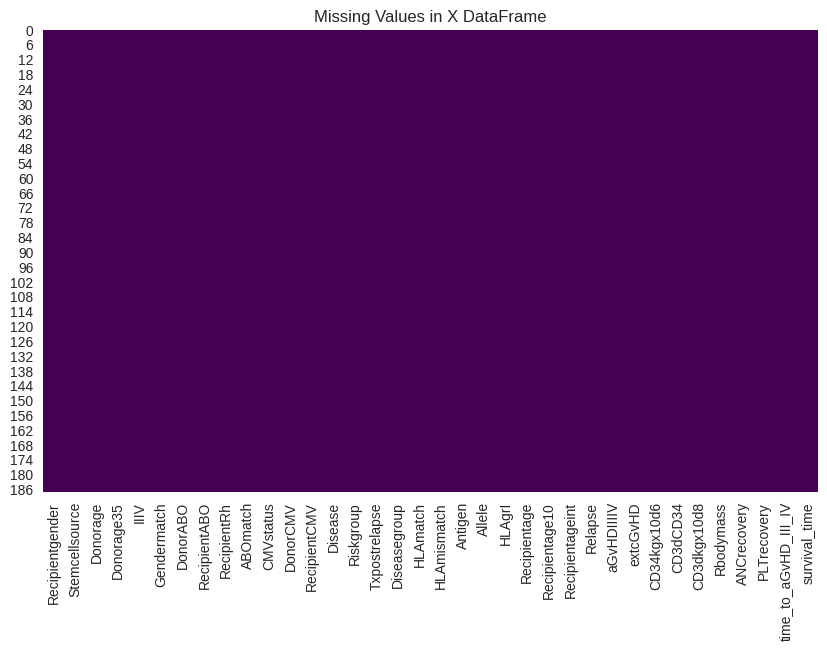

     Recipientgender  Stemcellsource   Donorage  Donorage35  IIIV  \
0                1.0             1.0  22.830137         0.0   1.0   
1                1.0             0.0  23.342466         0.0   1.0   
2                1.0             0.0  26.394521         0.0   1.0   
3                0.0             0.0  39.684932         1.0   1.0   
4                0.0             1.0  33.358904         0.0   0.0   
..               ...             ...        ...         ...   ...   
182              1.0             1.0  37.575342         1.0   1.0   
183              0.0             1.0  22.895890         0.0   0.0   
184              0.0             1.0  27.347945         0.0   1.0   
185              1.0             1.0  27.780822         0.0   1.0   
186              1.0             1.0  55.553425         1.0   1.0   

     Gendermatch  DonorABO  RecipientABO  RecipientRh  ABOmatch  ...  \
0            0.0       1.0           1.0          1.0       0.0  ...   
1            0.0      -1.0 

<ipython-input-22-52ec1b401dcc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])
<ipython-input-22-52ec1b401dcc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])


In [ ]:
# Missing Values in X DataFrame

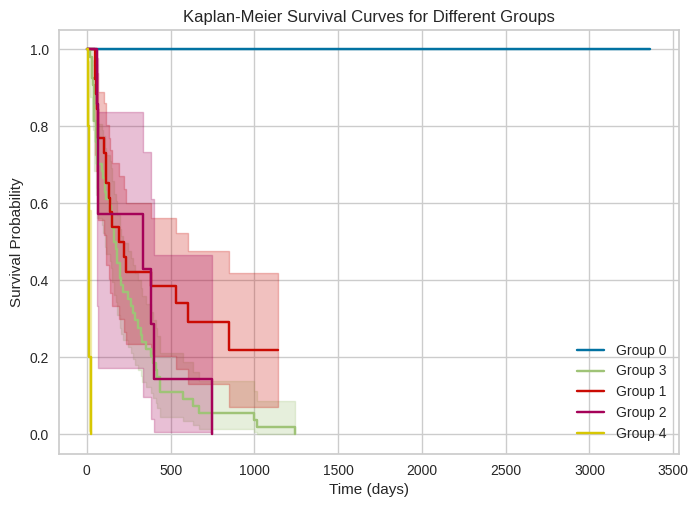

In [ ]:
"""
Compute the survival function for each group using Kaplan-Meier and Cox Regression.
Analyze the differences between both methods and the survival differences between groups.
In terms of interpretability, recall that Cox provides a feature importance.
"""

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Iterate through each group in your target
for group in data['cluster'].unique():
    group_data = data[data['cluster'] == group]  # Subset the data for the current group
    kmf.fit(durations=group_data['survival_time'], event_observed=group_data['survival_status'], label=f'Group {group}')

    # Plot the survival function for the group
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves for Different Groups')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [ ]:
# Initialize CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)

# Exclude 'cluster' from features used in the model
features_to_use = [col for col in data.columns if col not in ['survival_time', 'survival_status', 'cluster']] # Exclude 'cluster'

# 1. Check for high correlation:
# Calculate the correlation matrix
correlation_matrix = data[features_to_use].corr().abs()

# Filter for highly correlated features (e.g., correlation > 0.8)
highly_correlated = np.where(correlation_matrix > 0.8)
correlated_features = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*highly_correlated) if x != y and x < y]

# Print or examine the correlated_features list to identify potential issues
print("Highly correlated features:", correlated_features)

# 2. Remove highly correlated features (if necessary):
# Instead of removing just the first features, let's be more selective based on domain knowledge and the identified correlated pairs
# Remove features that are likely derived or redundant:
features_to_remove = correlated_features  # Add more as needed

# Extend features_to_remove based on highly correlated features
# You might need to add more features to this list based on domain knowledge and the output of correlated_features
# For example, if 'feature_a' and 'feature_b' are highly correlated, and 'feature_b' is deemed less important, add 'feature_b' to features_to_remove

features_to_remove = list(set(features_to_remove))  # Remove duplicates
features_to_use = [f for f in features_to_use if f not in features_to_remove]

# 3. Address potential complete separation (if applicable):
# Check if any feature perfectly predicts the outcome ('survival_status').
# This can be done by examining the relationship between each feature and survival_status.
# If found, you may need to consider strategies like regularization or removing the problematic feature.
# Example:
for feature in features_to_use:
    if data[[feature, 'survival_status']].groupby(feature)['survival_status'].nunique().max() == 1:
        print(f"Feature '{feature}' might cause perfect separation. Consider removing or regularizing it.")
        features_to_use.remove(feature)  # or apply regularization

# Fit the Cox Proportional Hazards model using selected features
#  (with potentially reduced features_to_use)
# Removed 'step_size' argument as it's not supported in the current version of lifelines
cph.fit(data[features_to_use + ['survival_time', 'survival_status']],
        duration_col='survival_time', event_col='survival_status')

# Print the summary of the model
cph.print_summary()

# Visualize the results (excluding 'cluster')
# TODO

Highly correlated features: [('Donorage', 'Donorage35'), ('CMVstatus', 'RecipientCMV'), ('Diseasegroup', 'Disease_nonmalignant'), ('HLAmatch', 'Antigen'), ('HLAmatch', 'Allele'), ('HLAmatch', 'HLAgrI'), ('HLAmismatch', 'HLAgrI'), ('Allele', 'HLAgrI'), ('Recipientage', 'Recipientage10'), ('Recipientage', 'Recipientageint'), ('Recipientage', 'Rbodymass'), ('Recipientage10', 'Recipientageint'), ('Recipientageint', 'Rbodymass'), ('aGvHDIIIIV', 'time_to_aGvHD_III_IV')]
Feature 'Donorage' might cause perfect separation. Consider removing or regularizing it.


<lifelines.CoxPHFitter: fitted with 187 total observations, 102 right-censored observations>
             duration col = 'survival_time'
                event col = 'survival_status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 187
number of events observed = 85
   partial log-likelihood = -369.48
         time fit was run = 2024-10-22 08:49:08 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Recipientgender      -0.03      0.97      0.23           -0.49            0.42                0.62                1.52
Stemcellsource       -0.09      0.91      0.28           -0.65            0.46                0.52                1.59
Donorage35            0.41      1.51      0.21           -0.00            0.83                1.00                2.28
IIIV                  0.04      1.04      0.24           -0.44            0.51                0.64                1.67
Gendermatch           0.12      1.13      0.30           -0.47            0.71                0.63                2.03
DonorABO              0.12      1.13      0.13           -0.13            0.37                0.88                1.45
RecipientABO         -0.06      0.94      0.12           -0.30            0.17                0.74                1.18
RecipientRh           0.74      2.10      0.33            0.10            1.38                1.11                3.97
ABOmatch             -0.07      0.93      0.24           -0.53            0.39                0.59                1.48
CMVstatus             0.01      1.01      0.15           -0.28            0.31                0.75                1.36
DonorCMV             -0.11      0.90      0.25           -0.60            0.38                0.55                1.46
RecipientCMV         -0.08      0.93      0.33           -0.72            0.57                0.49                1.77
Riskgroup             0.10      1.10      0.26           -0.41            0.60                0.67                1.83
Txpostrelapse        -0.10      0.90      0.33           -0.75            0.55                0.47                1.73
Diseasegroup         -0.07      0.93      0.48           -1.01            0.87                0.36                2.38
HLAmatch              0.06      1.06      0.25           -0.44            0.55                0.65                1.74
HLAmismatch          -0.32      0.72      0.41           -1.13            0.49                0.32                1.63
Antigen              -0.10      0.90      0.15           -0.39            0.18                0.68                1.20
Allele                0.15      1.16      0.18           -0.21            0.50                0.81                1.65
HLAgrI                0.05      1.05      0.11           -0.17            0.26                0.85                1.30
Recipientage          0.02      1.02      0.03           -0.05            0.09                0.95                1.09
Recipientage10        0.08      1.08      0.33           -0.57            0.73                0.56                2.07
Recipientageint      -0.07      0.93      0.21           -0.49            0.35                0.61                1.42
Relapse               0.95      2.59      0.28            0.41            1.50                1.50                4.47
aGvHDIIIIV           -0.40      0.67      0.41           -1.20            0.41                0.30                1.51
extcGvHD             -0.70      0.49      0.28           -1.25           -0.16                0.29                0.85
CD34kgx10d6           0.00      1.00      0.01           -0.02            0.03                0.98                1.03
CD3dCD34              0.00      1.00      0.01           -0.02            0.03                0.98            